In [1]:
from dataclasses import dataclass
from datetime import datetime
import pandas as pd

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer

In [2]:
batch_size = 256
learning_rate = 1e-3
weight_decay = 1e-2
labels_count = 10
num_epochs = 20
fuzzy_dim = 10

prefix = "anomaly_emnist"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## MNIST model training

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [4]:
def get_target(target_label):
    """
    Возвращает вектор целевого значения

    Args:
        target_label (int): Метка класса
    
    Returns:
        tensor (1, 10)
    """
    t = F.one_hot(torch.LongTensor([target_label]), labels_count)
    return t.to(device)

In [5]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target(x))
)

In [6]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target(x))
)
len(test_data)

10000

In [7]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [8]:
class Encoder(nn.Module):
    """
    Компонент энкодера
    
    Args:
        fuzzy_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, fuzzy_dim):
        super(Encoder, self).__init__()
                
        out_channels = 64
        self.encoder = nn.Sequential(
            
            nn.Conv2d(1, out_channels, kernel_size=5, padding=3),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(),  
            nn.Conv2d(out_channels, out_channels, kernel_size=5, padding=3),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(),  
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(out_channels, out_channels, kernel_size=5, padding=3),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(),  
            nn.Conv2d(out_channels, out_channels, kernel_size=5, padding=3),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(),  
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(out_channels, out_channels, kernel_size=5, padding=3),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(),  
            nn.Conv2d(out_channels, out_channels, kernel_size=5, padding=3),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(),  
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Flatten(),

            nn.Linear(3136 , fuzzy_dim),
            nn.BatchNorm1d(fuzzy_dim),
            # nn.Tanh(),  
            # nn.Tanh(),  
            # nn.Linear(968, fuzzy_dim),
            # nn.BatchNorm1d(fuzzy_dim),
            # nn.Tanh(),  
            # nn.Linear(4608, 2304),
            # nn.BatchNorm1d(2304),
            # nn.SiLU(),  
            # nn.Linear(2304, fuzzy_dim),
            # nn.BatchNorm1d(fuzzy_dim),
        )
         
    def forward(self, x):
        """
        Выход энкодера
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            encoded input
        """

        ex = self.encoder(x)
        
        return ex

In [9]:
inp = torch.rand((3, 1, 28, 28))
encoder = Encoder(2)
encoder.forward(inp).shape

torch.Size([3, 2])

In [10]:
class AnomalyDetection(nn.Module):
    """
    
    Args:
        fuzzy_dim (int): Размер латентного вектора.
        labels_count (int): Количество выходов классификатора
    """
    def __init__(self, fuzzy_dim, labels_count):
        super(AnomalyDetection, self).__init__()

        self.encoder = Encoder(fuzzy_dim)        
        
        self.fuzzy = nn.Sequential(
            # nn.SiLU(),  
            # nn.Linear(fuzzy_dim, labels_count),
            # nn.BatchNorm1d(labels_count),
            # nn.SiLU(),  
            # nn.Softmax(dim=1)
            FuzzyLayer.from_dimensions(fuzzy_dim, labels_count, trainable=True),
            #DefuzzyLinearLayer.from_dimensions(20, labels_count),
            # nn.Linear(20, labels_count),
            # nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        """
        
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            labels
        """

        ex = self.encoder(x)
        labels = self.fuzzy(ex)

        return labels

In [11]:
def compute_loss(target_labels, predicted_labels):

    ceLoss = nn.CrossEntropyLoss(reduction="sum")
    
    loss_fuzzy = ceLoss.forward(predicted_labels, torch.squeeze(target_labels,1).float())

    return loss_fuzzy
    

In [12]:
model = AnomalyDetection(fuzzy_dim, labels_count).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 547,242


AnomalyDetection(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SiLU()
      (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): SiLU()
      (10): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
      (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): SiLU()
      (13): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (14): Co

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [14]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        labels = model.forward(data)  
        
        loss = compute_loss(target, labels)
        
        loss.backward()
        
        if n_upd % 100 == 0:
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            #print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [15]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_loss = 0
    test_accuracy = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            
            labels = model.forward(data)  
            
            loss = compute_loss(target, labels)
            
            test_loss += loss.item()
            
            pred_target = np.argmax(labels.cpu().numpy(), axis=1)
            target_labels =  np.argmax(torch.squeeze(target,1).cpu().numpy(), axis=1)
            test_accuracy += np.sum(target_labels==pred_target) / len(pred_target)

    test_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    print(f'====> Test set loss: {test_loss:.4f} (Accuracy {test_accuracy:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Accuracy', test_accuracy, global_step=cur_step)

In [16]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/20


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 420.3887 (Accuracy 0.9837)
Epoch 2/20


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 417.1892 (Accuracy 0.9869)
Epoch 3/20


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 401.0297 (Accuracy 0.9902)
Epoch 4/20


  0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 399.2393 (Accuracy 0.9921)
Epoch 5/20


  0%|          | 0/235 [00:00<?, ?it/s]

In [ ]:
# encode and plot the z values for the train set 
model.eval()
features2d = []
labels_predicted = []
labels_expected = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        ft = model.encoder.forward(data)
        labs = model.forward(data)
        features2d.append(ft.cpu().numpy())
        labels_predicted.append(np.argmax(labs.cpu().numpy(), axis=1))
        labels_expected.append(np.argmax(target.squeeze(1).cpu().numpy(), axis=1))

features2d = np.concatenate(features2d, axis=0)
labels_predicted = np.concatenate(labels_predicted, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)
        

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

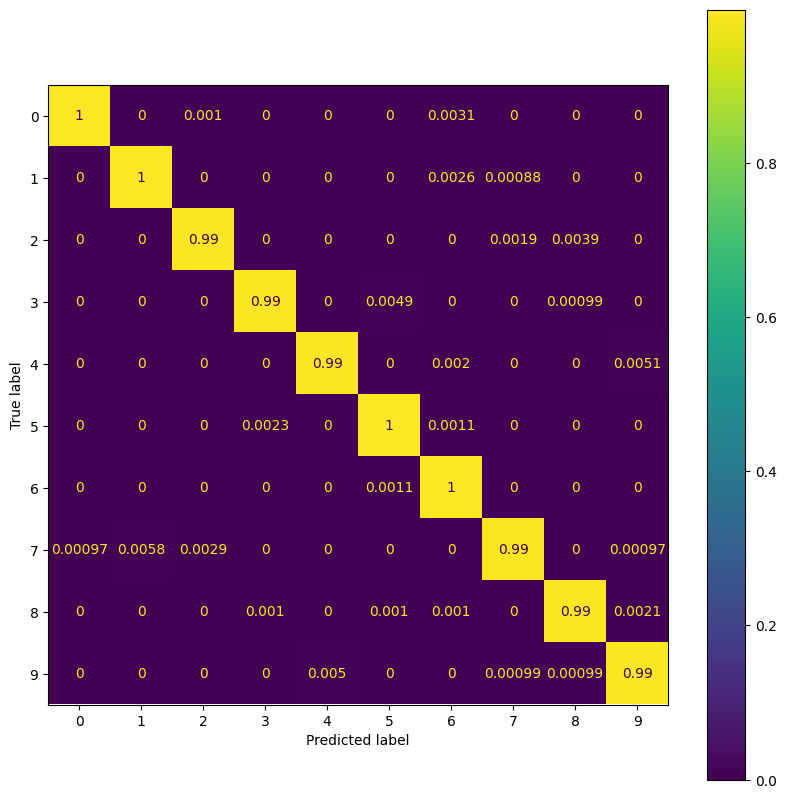

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels_predicted, labels_expected, normalize='true')
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)

Text(0, 0.5, 'feature 2')

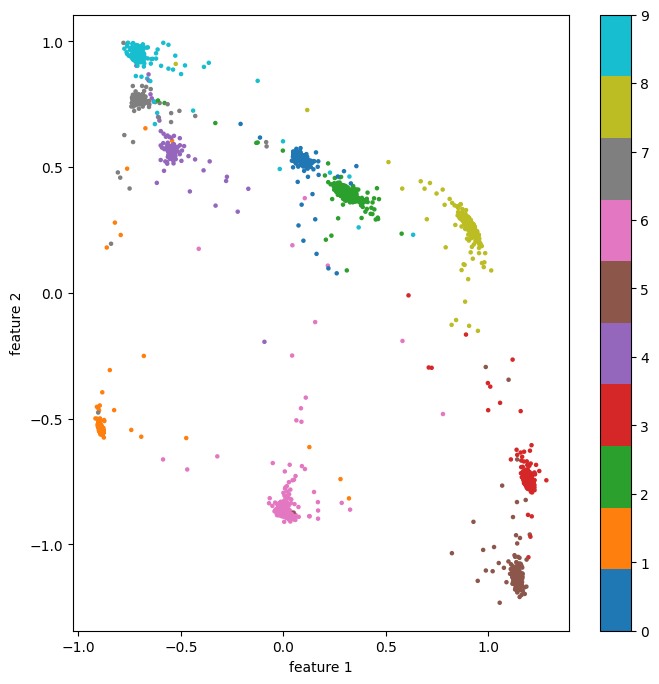

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(features2d[:, 0], features2d[:, 1], c=labels_expected, cmap='tab10', s=5)
plt.colorbar()
plt.xlabel("feature 1")
plt.ylabel("feature 2")

## EMNIST Loading

In [ ]:
emnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

emnist_test = pd.read_csv("./data/EMNIST/emnist-letters.csv")
emnist_y = emnist_test["label"]
emnist_x = emnist_test.drop(labels = ["label"], axis = 1) 
del emnist_test 

emnist_x = emnist_x / 255.0
emnist_x = emnist_x.values.reshape(-1, 28, 28)
emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32) for a in emnist_x]

len(emnist_x)

emnist_mapping = pd.read_csv("./data/EMNIST/emnist-letters-mapping.txt", sep=' ', header=None)
emnist_mapping.columns=("EMNIST","UP","LO")
emnist_mapping["Letter"] = emnist_mapping.apply(lambda row: chr(row["UP"])+chr(row["LO"]), axis=1)
emnist_mapping = dict(zip(emnist_mapping["EMNIST"], emnist_mapping["Letter"]))
emnist_mapping

C:\Users\Юрий\AppData\Local\Temp\ipykernel_13576\3359267760.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32) for a in emnist_x]


{1: 'Aa',
 2: 'Bb',
 3: 'Cc',
 4: 'Dd',
 5: 'Ee',
 6: 'Ff',
 7: 'Gg',
 8: 'Hh',
 9: 'Ii',
 10: 'Jj',
 11: 'Kk',
 12: 'Ll',
 13: 'Mm',
 14: 'Nn',
 15: 'Oo',
 16: 'Pp',
 17: 'Qq',
 18: 'Rr',
 19: 'Ss',
 20: 'Tt',
 21: 'Uu',
 22: 'Vv',
 23: 'Ww',
 24: 'Xx',
 25: 'Yy',
 26: 'Zz'}

In [ ]:
emnist_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.stack(emnist_x), torch.Tensor(np.array(emnist_y))), 
    batch_size=batch_size, 
    shuffle=False,
)

### Anomaly Detection

In [ ]:
def ametrics(anomaly_rates):
    mean_ar = np.mean(anomaly_rates)
    plow_ar = np.percentile(anomaly_rates, 20)
    phigh_ar = np.percentile(anomaly_rates, 80)

    return mean_ar, plow_ar, phigh_ar

In [ ]:
model.eval()

firings_mnist = {}
for m in range(10):
    firings_mnist[m] = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        
        labs = model.forward(data)
        for k,v in zip(np.concatenate(target.argmax(axis=2).cpu().numpy(), axis=0), np.max(labs.cpu().numpy(), axis=1)):
            firings_mnist[k].append(v)
        



Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
for k in range(10):
    print(f"{k}: {ametrics(firings_mnist[k])}")

0: (0.93868273, 0.9423921704292297, 0.9523105502128602)
1: (0.96432793, 0.9656842112541199, 0.9790037870407104)
2: (0.92079175, 0.9188179731369018, 0.933713960647583)
3: (0.91756046, 0.9185147047042846, 0.9331710696220398)
4: (0.9468529, 0.9535815954208374, 0.962390410900116)
5: (0.9214869, 0.923753559589386, 0.9358673095703125)
6: (0.92232096, 0.9210689306259155, 0.9487646579742431)
7: (0.9551069, 0.9581528306007385, 0.9712517857551575)
8: (0.9213848, 0.9246366381645202, 0.9450416207313538)
9: (0.90786713, 0.9129237771034241, 0.9327751159667969)


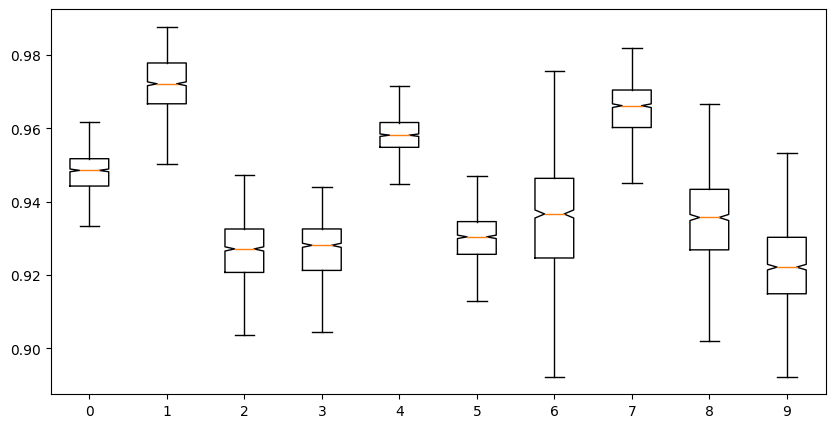

In [ ]:
labels, data = firings_mnist.keys(), firings_mnist.values()
fig = plt.figure(figsize =(10, 5))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

In [ ]:
model.eval()

firings_emnist = {}
for m in emnist_mapping:
    firings_emnist[emnist_mapping[m]] = []

with torch.no_grad():
    for data, labels in tqdm(emnist_loader, desc='Encoding'):
        data = data.view((-1, 1, 28, 28)).to(device)
        flabels = model.forward(data)
        
        for label, flabel in zip(labels, np.max(flabels.cpu().numpy(), axis=1)):
            firings_emnist[emnist_mapping[label.item()]].append(flabel)

Encoding:   0%|          | 0/405 [00:00<?, ?it/s]

In [ ]:
for m in emnist_mapping:
    k = emnist_mapping[m]
    print(f"{k}: {ametrics(firings_emnist[k])}")


Aa: (0.41672716, 0.21263839304447174, 0.6387829184532166)
Bb: (0.37211162, 0.23463228344917297, 0.5014384984970093)
Cc: (0.40016732, 0.2067138731479645, 0.6055732011795044)
Dd: (0.36651376, 0.16556537747383118, 0.5856919527053834)
Ee: (0.40497416, 0.19728235006332398, 0.605764627456665)
Ff: (0.24570207, 0.1303555190563202, 0.3329777121543884)
Gg: (0.3640859, 0.20972474217414858, 0.4959051370620728)
Hh: (0.37634116, 0.1894674450159073, 0.5443578362464905)
Ii: (0.2981848, 0.16004865169525145, 0.3890781342983247)
Jj: (0.318704, 0.16281871497631073, 0.4499477744102478)
Kk: (0.24875608, 0.1417107790708542, 0.3295920431613923)
Ll: (0.3956697, 0.1639965534210205, 0.7158487796783448)
Mm: (0.32359335, 0.18123106360435487, 0.4480083823204041)
Nn: (0.4848885, 0.19725697636604309, 0.8599197983741761)
Oo: (0.88323754, 0.8819440484046936, 0.9473900198936462)
Pp: (0.37895405, 0.16447595953941346, 0.6224574327468873)
Qq: (0.41050228, 0.23910743296146394, 0.5884793877601624)
Rr: (0.27710345, 0.13227919

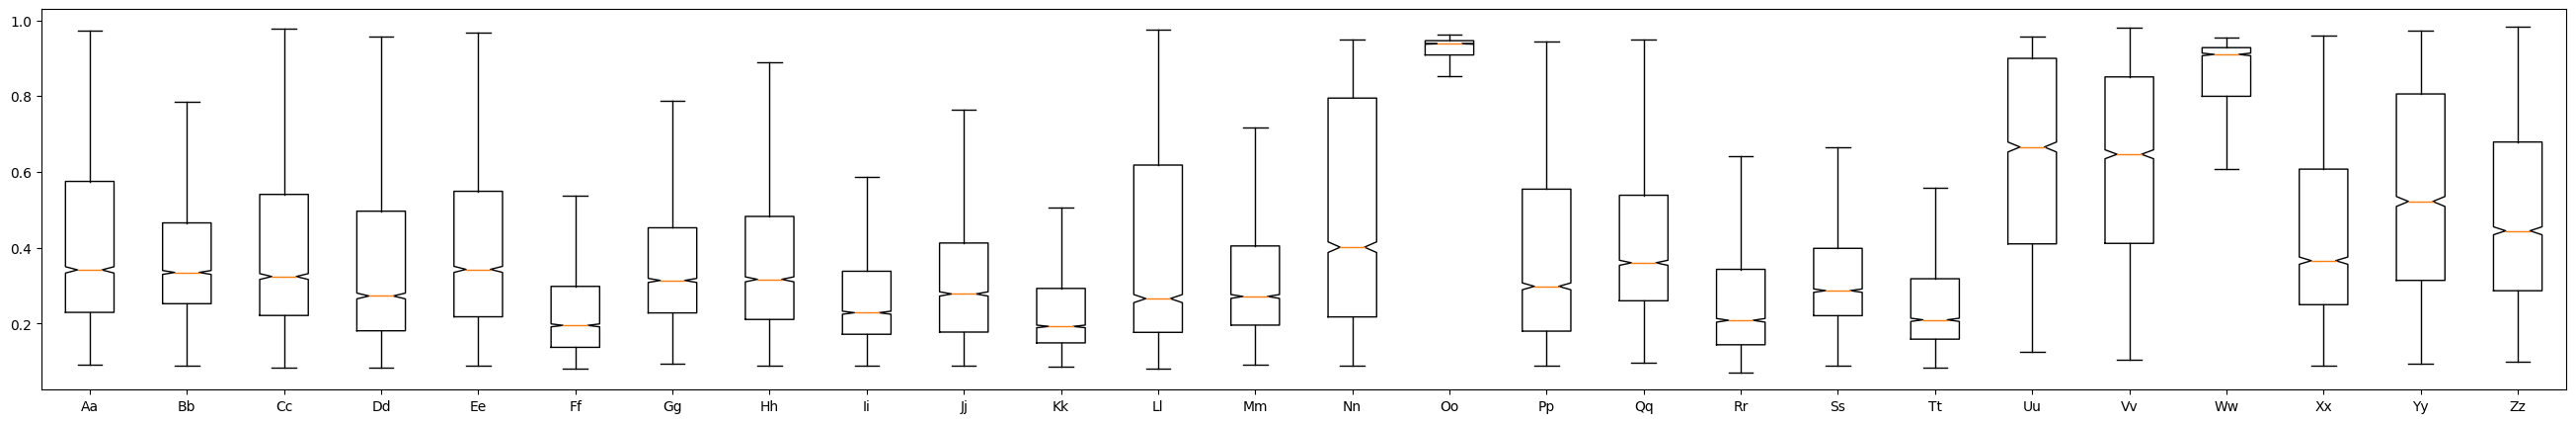

In [ ]:
labels, data = firings_emnist.keys(), firings_emnist.values()
fig = plt.figure(figsize =(33, 5))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

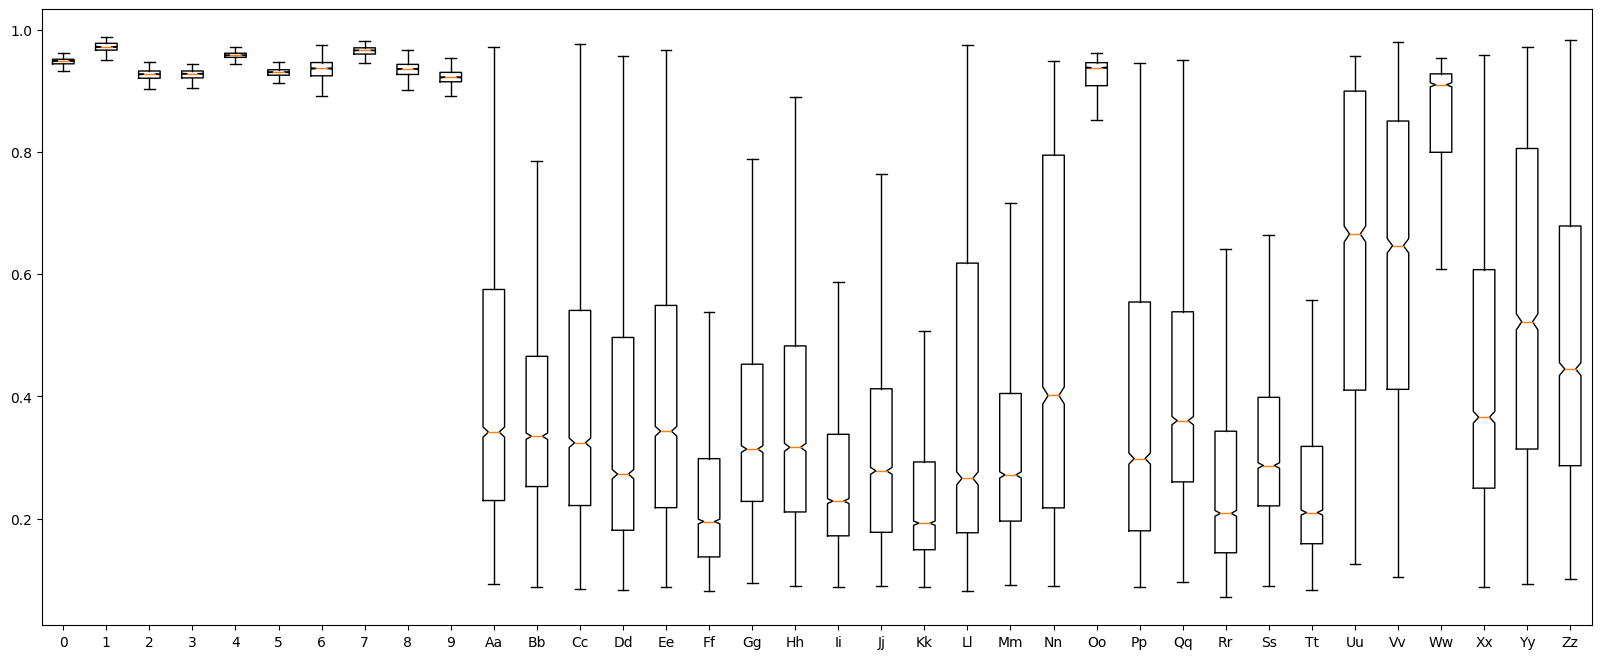

In [ ]:
firings = {**firings_mnist, **firings_emnist} 
labels, data = firings.keys(), firings.values()

fig = plt.figure(figsize =(20, 8))
#plt.ylim(ymin=0)
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

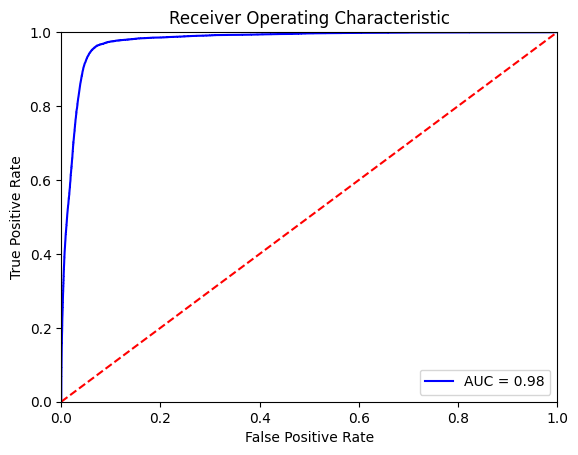

In [ ]:
import sklearn.metrics as metrics

lab_true = []
lab_pred = []
for k,v in firings_mnist.items():
    for p in v:
        lab_true.append(1)
        lab_pred.append(p)
for k,v in firings_emnist.items():
    if k == 'Oo':
        continue
    for p in v:
        lab_true.append(0)
        lab_pred.append(p)

fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

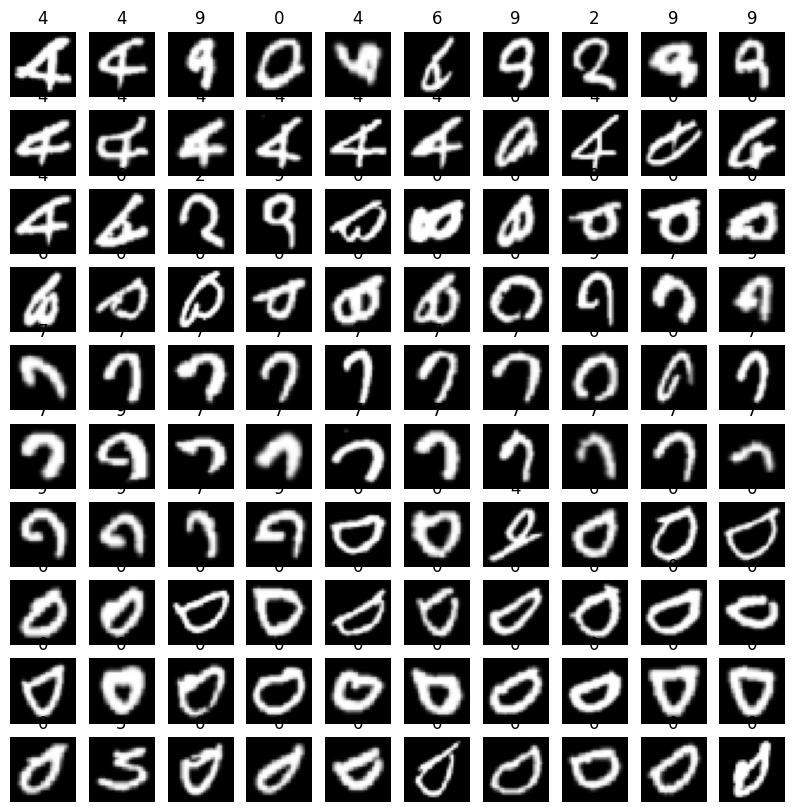

In [ ]:
n = 0
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
with torch.no_grad():
    for data, label in zip(emnist_x, emnist_y):
        #if emnist_mapping[label] == 'Ww':
            data = data.view((-1, 1, 28, 28)).to(device)
            flabel = model.forward(data)

            if np.max(flabel.cpu().numpy(), axis=1)[0] > 0.9:
                
                ax[int(n / 10), int(n % 10)].imshow(data.view(28, 28).cpu().detach().numpy(), cmap='gray')
                ax[int(n / 10), int(n % 10)].axis('off')
                ax[int(n / 10), int(n % 10)].set_title(np.argmax(flabel.cpu().numpy(), axis=1)[0])
                n = n + 1
                
                if n == 100:
                    break
